# Introduction



All zebrafish tailbuds were stained with DAPI for nuclear DNA detection prior to microscopy imaging. On top of the DNA stain, combinations of mRNA sequences were also labelled with distinct fluorophores using the `Hybridisation Chain Reaction (HCR)` technique. Consequently, for our data, our images range from having 1 (DAPI only) up to 6 (DAPI and 5 other fluorophores) color channels. 

For two images with at least 1 color channel in common, the shared color channel confers additional information that we can leverage to assess the quality of the image registration. We do this by quantifying the difference in normalised signal intensities between the shared color channel of the 2 images (color intensity residual) after image registration is performed. Using this metric, we expect the optimal image registration output to show the smallest color intensity residual. However, it is obvious that images of different zebrafish tailbuds, even if registered optimally, will *always* differ in their color intensities due to biological variability (different rates of development, stochasticity in nuclear positioning etc.). The relevant question, therefore, is whether the residual is smaller than the cases where the images were poorly registered.

**Null hypothesis**: Image registration has no effect in reducing the color intensity residuals.

**Alternate hypothesis**: Image registration reduces the color intensity residuals.


## The mean absolute error (MAE) test statistic


To quantify the residuals, we chose the mean absolute error ${\rm MAE} = \frac {1} {n} \sum_{i=1}^{n}
\mid{y_i - x_i}\mid$ as our summary statistic, which measures the error between paired observations of a phenomenon. Its chief advantage over related measures such as the root mean-squared error (RMSE) lie in increased interpretability, as each residual contributes proportionately (as opposed to quadratically in the case of the RMSE) to the overall MAE statistic. In addition, no computational difficulty arises when the intensity of a target point is 0, which occurs when the target point is unmapped.

Using the MAE as our test statistic, we will conduct a permutation test. Briefly, we construct the MAE distribution under the null hypothesis and obtain the probability of observing a result as extreme as the registration's MAE value, assuming that the null hypothesis were true (p-value). 

In [57]:
import numpy as np 
import pandas as pd
import open3d as o3d
import copy
import matplotlib.pyplot as plt
import matplotlib.colors as col
import seaborn as sns
import scipy.stats as st

from data_processing import excel_to_pcd, preprocess_point_cloud, process_images, colour_map
from align_func import execute_global_registration, icp_registration, colored_icp, calculate_mae


In [16]:
def process_color(filepath, skiprows, usecols):
    color_excel = pd.read_excel(filepath, skiprows = skiprows, header = 0, usecols = usecols) 
    image_color = color_excel.to_numpy(dtype='float64')
    min_intensity=np.amin(image_color)
    max_intensity=np.amax(image_color)
    norm_color = (image_color - min_intensity) / (max_intensity - min_intensity) *100 
    return norm_color

def mae_permutation(num_permute, color_array):
    mae_list = []
    for i in range(num_permute):
        np.random.seed(i)
        x = np.random.permutation(color_array)
        x = np.reshape(x, color_array.shape)
        mae_val = (sum(abs(x - color_array))) / (x.shape[0])
        mae_val_rounded = round(float(mae_val),3) 
        mae_list.append(mae_val_rounded)
    return mae_list

# Null MAE distribution

In [3]:
target_path = "./datasets/2-permutation/xyz_target.xls"
source_path = "./datasets/2-permutation/xyz_source.xls"
target_color_path = "./datasets/2-permutation/sox2_target.xls"
source_color_path = "./datasets/2-permutation/sox2_source.xls"

target_color = process_color(target_color_path, [0,1,2], [0])
source_color = process_color(source_color_path, [0,1,2], [0])

In [50]:
num_permute = 1000
mae_null = mae_permutation(num_permute, target_color)
loc, scale = st.norm.fit(mae_null)
st.norm.interval(alpha=0.95, loc=loc, scale=scale) 

(13.69739871175013, 14.33857328824987)

# MAE value of Colored ICP registration 

In [23]:
positions_paths = [source_path] + [target_path]
color_paths = [source_color_path] + [target_color_path]

pcd,fpfh,image_rgb = process_images(positions_paths, color_paths, skiprows = [0,1,2])

source, target = pcd
source_fpfh,target_fpfh = fpfh
source_rgb, target_rgb = image_rgb

:: Point Cloud was not downsampled
:: Estimate normal with search radius 20.
:: Compute FPFH feature with search radius 50.
---------------------------------------
:: Point Cloud was not downsampled
:: Estimate normal with search radius 20.
:: Compute FPFH feature with search radius 50.
---------------------------------------


In [24]:
result_ransac_rotate = execute_global_registration(source, target,
                                            source_fpfh, target_fpfh)

result_colored_icp = colored_icp(source, target, result_ransac_rotate.transformation, voxel_radius = 10, coloredICP_maxnn = 50, downsample = False)

mae_regis = calculate_mae(source_rgb, target_rgb, result_colored_icp)

In [26]:
mae_regis

3.2269446405967814

# Plotting results

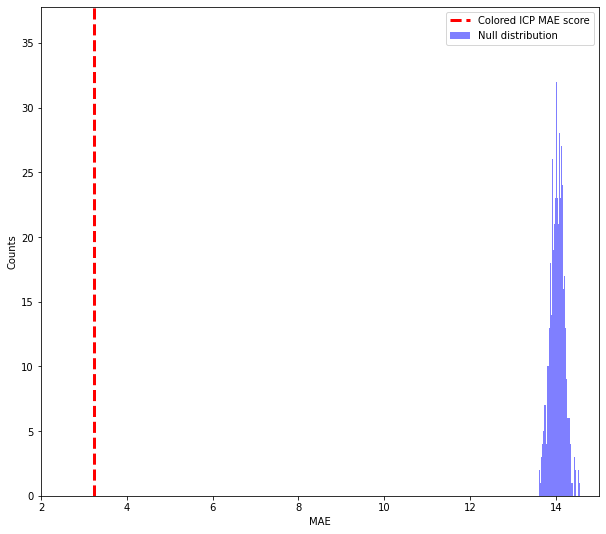

In [63]:
kwargs = dict(alpha=0.5, bins=100)
fig = plt.figure(figsize = (10,9))

plt.hist(mae_null, **kwargs, color='b', label='Null distribution')
plt.axvline(x=mae_regis, linewidth=3.0, linestyle = '--', color = 'r', label = "Colored ICP MAE score")

plt.gca().set(xlabel = "MAE", ylabel='Counts')
plt.xlim(2,15)
plt.legend(loc = "upper right");

# Conclusion